# Predicting the stock market

Importing the necessary packages

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import quandl
import datetime
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD

plt.style.use('fivethirtyeight') #For good visuals

Using TensorFlow backend.


Importing the IBM stock data in the time period 2005-2017

In [0]:
initial = datetime.datetime(2005,1,1)
final = datetime.datetime(2017, 12, 31)
quandl.ApiConfig.api_key = 'your quandl id here'
data = quandl.get("WIKI/IBM", start_date=initial, end_date=final)

In [5]:
data.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2005-01-03,98.97,99.10,97.25,97.75,5295200.0,0.0,1.0,75.008235,75.106761,73.704667,74.083611,5295200.0
2005-01-04,97.74,98.42,96.52,96.70,5711000.0,0.0,1.0,74.076032,74.591396,73.151408,73.287828,5711000.0
2005-01-05,96.60,97.83,96.40,96.50,5646700.0,0.0,1.0,73.212039,74.144242,73.060461,73.136250,5646700.0
2005-01-06,96.54,96.98,96.05,96.20,4561700.0,0.0,1.0,73.166566,73.500037,72.795200,72.908884,4561700.0
2005-01-07,96.50,96.80,95.47,95.78,6200700.0,0.0,1.0,73.136250,73.363617,72.355625,72.590570,6200700.0


Visualizing the data

In [0]:
def time_series(dataframe, title):
  dataframe["High"].plot(figsize=(18,9),legend=True)
  plt.title(title)
  plt.show()

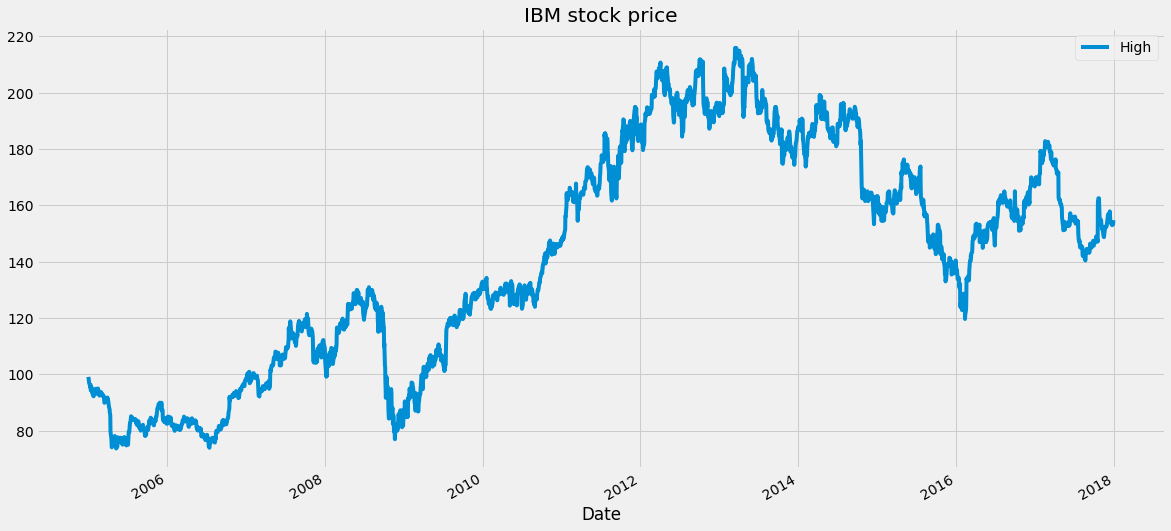

In [7]:
title = 'IBM stock price'
time_series(data,title)

Creating the training and test sets with a 70:30 split of the data. Only 'High' values will be used in this notebook

---



In [0]:
def split_data(dataframe):
  training_set = dataframe[:'2013'].iloc[:,1:2].values
  test_set = dataframe['2014':].iloc[:,1:2].values
  return training_set, test_set

In [0]:
training_set, test_set = split_data(data)

Scaling the training set such that features end up in the range 0-1 inclusive

In [0]:
scale = MinMaxScaler(feature_range=(0,1))
training_scaled = scale.fit_transform(training_set)

Here, preparing the data to be used with an LSTM. More specifically, modifying the data such that we end up with 60 timesteps and 1 output. So for each element of the training set, we have 60 previous training set elements

In [0]:
def revised_train_data(training_data):
  length = len(training_data)
  X_train = []
  y_train = []
  for i in range(60,length):
    X_train.append(training_data[i-60:i,0])
    y_train.append(training_data[i,0])
  return np.array(X_train), np.array(y_train)

In [0]:
X_train, y_train = revised_train_data(training_scaled)

Reshaping X_train for easy modelling

In [0]:
def reshape_X_train(X_data):
  X_train = np.reshape(X_data, (X_data.shape[0],X_data.shape[1],1))
  return X_train

In [0]:
X_train = reshape_X_train(X_train)

Training our LSTM model. After experimenting with several models, it turns out that the one presented shows good performance

In [49]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=7,batch_size=32)

Epoch 1/7
2205/2205 [==============================] - 28s 13ms/step - loss: 0.0201
Epoch 2/7
2205/2205 [==============================] - 27s 12ms/step - loss: 0.0092
Epoch 3/7
2205/2205 [==============================] - 26s 12ms/step - loss: 0.0075
Epoch 4/7
2205/2205 [==============================] - 26s 12ms/step - loss: 0.0061
Epoch 5/7
2205/2205 [==============================] - 26s 12ms/step - loss: 0.0056
Epoch 6/7
2205/2205 [==============================] - 26s 12ms/step - loss: 0.0048
Epoch 7/7
2205/2205 [==============================] - 26s 12ms/step - loss: 0.0053


The test data is modified in the same way as the training data. The 60 entries before the first test entry are being taken into account to be consistent with the scaling

In [0]:
def scaled_test_data(dataframe, test_set,scale):
  data_cumulative = pd.concat((dataframe["High"][:'2013'],dataframe["High"]['2014':]),axis=0)
  inputs = data_cumulative[len(data_cumulative)-len(test_set) - 60:].values
  inputs = inputs.reshape(-1,1)
  inputs  = scale.transform(inputs)
  return inputs

In [0]:
inputs = scaled_test_data(data, test_set,scale)

With the right test data set in hand, it can be prepped for comparison

In [0]:
def revised_X_test(data):
  X_test = []
  for i in range(60,len(data)):
    X_test.append(data[i-60:i,0])
  X_test = np.array(X_test)
  X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
  return X_test

In [0]:
X_test = revised_X_test(inputs)

Predicting the prices

In [0]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = scale.inverse_transform(predicted_stock_price)

Defining functions for plotting and calculating RMSE

In [0]:
def plot_comparison(test,predicted):
    plt.figure(figsize=(18,9))
    plt.plot(test, color='blue',label='Real IBM Stock Price')
    plt.plot(predicted, color='green',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time (days)')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def calculate_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

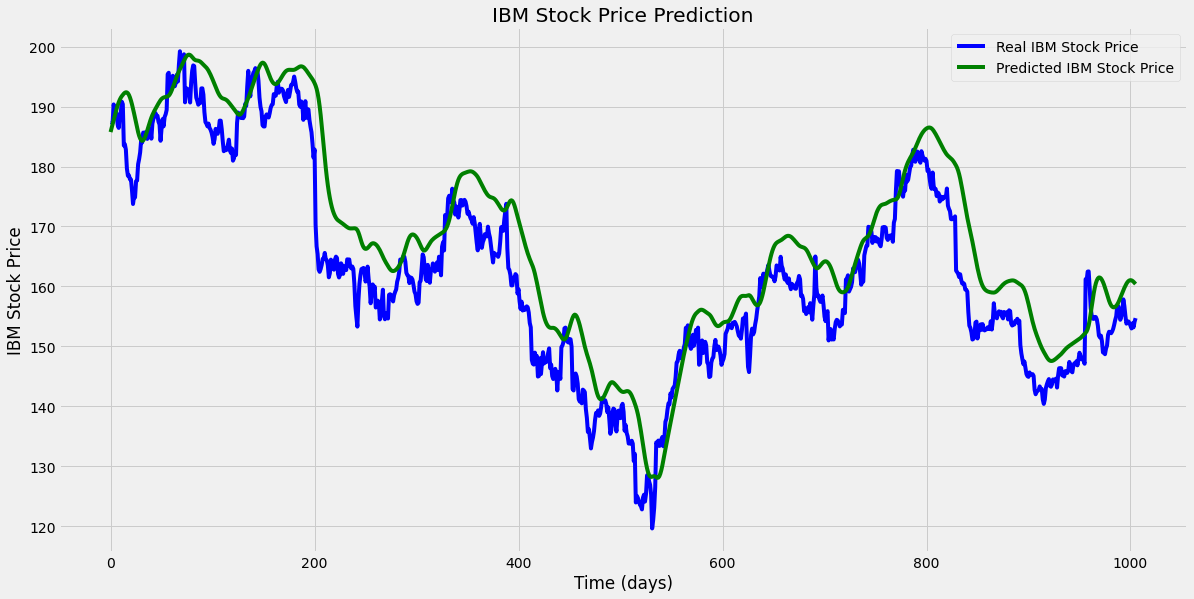

In [53]:
plot_comparison(test_set,predicted_stock_price)

In [54]:
calculate_rmse(test_set,predicted_stock_price)


The root mean squared error is 7.4133514689135955.


This is a good result. The model can be made better by finetuning the parameters

Let's train a GRU network now

In [46]:
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=7,batch_size=150)

Epoch 1/7
2205/2205 [==============================] - 9s 4ms/step - loss: 0.1235
Epoch 2/7
2205/2205 [==============================] - 7s 3ms/step - loss: 0.0609
Epoch 3/7
2205/2205 [==============================] - 7s 3ms/step - loss: 0.0179
Epoch 4/7
2205/2205 [==============================] - 7s 3ms/step - loss: 0.0061
Epoch 5/7
2205/2205 [==============================] - 8s 3ms/step - loss: 0.0045
Epoch 6/7
2205/2205 [==============================] - 8s 3ms/step - loss: 0.0041
Epoch 7/7
2205/2205 [==============================] - 7s 3ms/step - loss: 0.0038


In [0]:
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = scale.inverse_transform(GRU_predicted_stock_price)

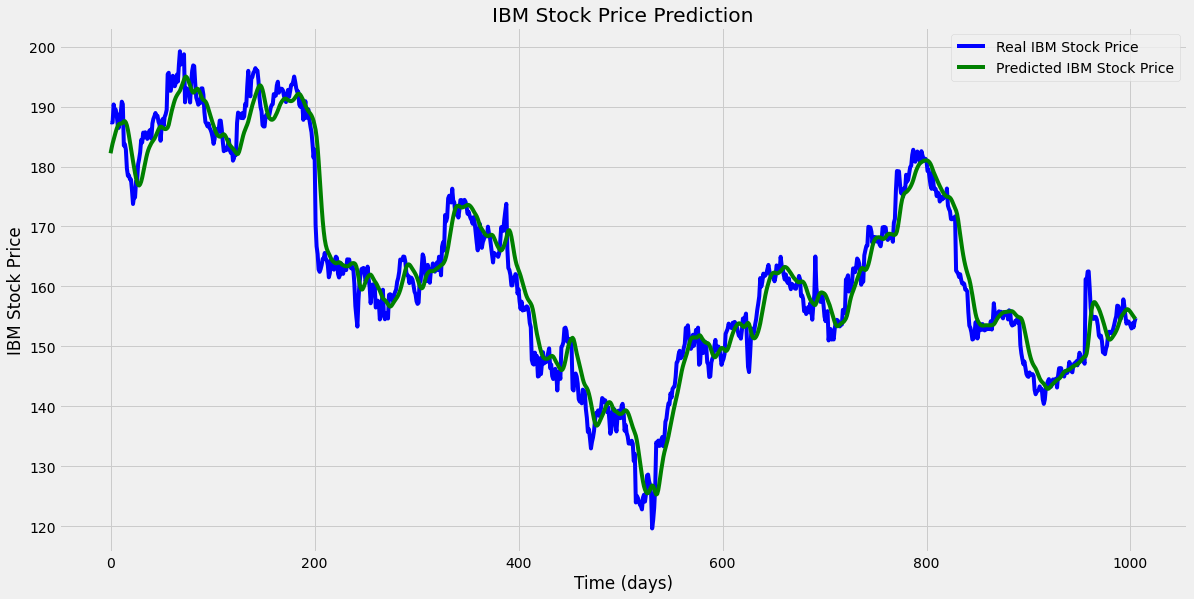

The root mean squared error is 3.6545065161693193.


In [48]:
plot_comparison(test_set,GRU_predicted_stock_price)
calculate_rmse(test_set,GRU_predicted_stock_price)

This model turns out to be better than the first one because the RMSE is smaller. It also trained faster and hence consumes less resources. Both models can probably be made better with more data